In [6]:
from network import Model
from game import Game
from train import PPOTrainer
from player import NNAgent, EVAgent

import matplotlib.pyplot as plt
import numpy as np
import torch

In [7]:
NUM_GAMES = 2000
NUM_TRIALS = 1000
DEVICE = 'cpu'

trained_results = []
non_trained_results = []
input_space = 10
win_threshold = .55

action_space = list(range(3, 19)) #place a bid, place an ask
train_model = Model(input_space, len(action_space))
# train_model.load_state_dict(torch.load('training_against_ev.pth')) 
prev_best = Model(input_space, len(action_space))
# prev_best.load_state_dict(torch.load('beats_ev.pth')) 
trainer = PPOTrainer(train_model, policy_lr=1e-4, value_lr=1e-3)
win_history = []

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
count_parameters(train_model)

215889

In [10]:
import copy
beat_ev = False

for trial in range(NUM_TRIALS):

    # Self play
    training_data = [np.empty((0, 10)), np.empty(0,), np.empty(0,), np.empty(0,), np.empty(0,)]
    print(f'TRIAL {trial + 1}')
    for _ in range(NUM_GAMES):
        # print(f'GAME {_ + 1}')
        p1 = NNAgent(train_model)
        p2 = NNAgent(train_model)
        # p2 = EVAgent()
        game = Game(p1, p2)
        data = game.play()
        for i in range(len(training_data)):
            training_data[i] = np.append(training_data[i], data[i], axis=0)
            # print(f'Player {i}: {profit}')

    permute_idxs = np.random.permutation(len(training_data[0]))[:2048]

    # Policy data
    obs = torch.tensor(training_data[0][permute_idxs], dtype=torch.float32, device=DEVICE)
    acts = torch.tensor(training_data[1][permute_idxs], dtype=torch.int32, device=DEVICE)
    advantages = torch.tensor(training_data[3][permute_idxs], dtype=torch.float32, device=DEVICE)
    act_log_probs = torch.tensor(training_data[4][permute_idxs], dtype=torch.float32, device=DEVICE)

    # Value data
    returns = torch.tensor(training_data[2], dtype=torch.float32, device=DEVICE)

    # Train
    trainer.train_policy(obs, acts, act_log_probs, advantages)
    trainer.train_value(obs, returns)

    # Play previous benchmark
    win_count = 0
    loss_count = 0
    for _ in range(NUM_GAMES):
        p1 = NNAgent(train_model)
        # if beat_ev:
        #     p2 = NNAgent(prev_best)
        # else:
        #     p2 = EVAgent()
        p2 = EVAgent()
        game = Game(p1, p2)
        game.play()
        if p1.final_profit(game.cards_sum) > p2.final_profit(game.cards_sum):
            win_count += 1
        elif p1.final_profit(game.cards_sum) < p2.final_profit(game.cards_sum):
            loss_count += 1
        else:
            if abs(p1.state['card'] - 5.5) < abs(p2.state['card'] - 5.5): # i have a worse card
                win_count += 1
            elif abs(p1.state['card'] - 5.5) > abs(p2.state['card'] - 5.5):
                loss_count += 1
    
    print(f'Trained model won {win_count * 100 / (win_count + loss_count)}% of the games')
    if win_count / (win_count + loss_count) >= win_threshold:
        state_dict = copy.deepcopy(train_model.state_dict())
        prev_best = Model(input_space, len(action_space))
        prev_best.load_state_dict(state_dict)
        beat_ev = True
    win_history.append(win_count * 100 / (win_count + loss_count))

TRIAL 1


Training value net: 100%|██████████| 80/80 [00:29<00:00,  2.69it/s]


Trained model won 33.01069791136016% of the games
TRIAL 2


Training value net: 100%|██████████| 80/80 [00:30<00:00,  2.61it/s]


Trained model won 36.60030627871363% of the games
TRIAL 3


Training value net: 100%|██████████| 80/80 [00:30<00:00,  2.62it/s]


Trained model won 37.05017739483021% of the games
TRIAL 4


Training value net: 100%|██████████| 80/80 [00:31<00:00,  2.52it/s]


Trained model won 38.24884792626728% of the games
TRIAL 5


Training value net: 100%|██████████| 80/80 [00:30<00:00,  2.61it/s]


Trained model won 34.82460599898322% of the games
TRIAL 6


Training value net: 100%|██████████| 80/80 [00:30<00:00,  2.64it/s]


Trained model won 34.14758269720102% of the games
TRIAL 7


Training value net: 100%|██████████| 80/80 [00:31<00:00,  2.51it/s]


Trained model won 38.36734693877551% of the games
TRIAL 8


Training value net: 100%|██████████| 80/80 [00:33<00:00,  2.39it/s]


Trained model won 36.082995951417004% of the games
TRIAL 9


Training value net: 100%|██████████| 80/80 [00:33<00:00,  2.40it/s]


Trained model won 37.81426372498717% of the games
TRIAL 10


Training value net: 100%|██████████| 80/80 [00:33<00:00,  2.40it/s]


Trained model won 38.17533129459735% of the games
TRIAL 11


Training value net: 100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


Trained model won 38.339313172731934% of the games
TRIAL 12


Training value net: 100%|██████████| 80/80 [00:44<00:00,  1.79it/s]


Trained model won 37.150127226463106% of the games
TRIAL 13


Training value net: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]


Trained model won 38.888888888888886% of the games
TRIAL 14


Training value net: 100%|██████████| 80/80 [00:30<00:00,  2.62it/s]


Trained model won 38.57658586900464% of the games
TRIAL 15


Training value net: 100%|██████████| 80/80 [00:30<00:00,  2.64it/s]


Trained model won 40.706605222734254% of the games
TRIAL 16


Training value net: 100%|██████████| 80/80 [00:37<00:00,  2.14it/s]


Trained model won 34.695963208993355% of the games
TRIAL 17


Training value net: 100%|██████████| 80/80 [00:40<00:00,  1.99it/s]


Trained model won 37.086092715231786% of the games
TRIAL 18


Training value net: 100%|██████████| 80/80 [00:44<00:00,  1.78it/s]


Trained model won 35.57594291539246% of the games
TRIAL 19


Training value net: 100%|██████████| 80/80 [00:47<00:00,  1.68it/s]


Trained model won 36.724313326551375% of the games
TRIAL 20


Training value net: 100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


Trained model won 35.786802030456855% of the games
TRIAL 21


Training value net: 100%|██████████| 80/80 [00:49<00:00,  1.63it/s]


Trained model won 38.0539989811513% of the games
TRIAL 22


KeyboardInterrupt: 

In [11]:
torch.save(train_model.state_dict(), 'training_against_ev.pth')

In [ ]:
win_count = 0
loss_count = 0
for _ in range(NUM_GAMES * 20):
    p1 = NNAgent(prev_best)
    p2 = EVAgent()
    game = Game(p1, p2)
    game.play(train=False)
    if p1.final_profit(game.cards_sum) > p2.final_profit(game.cards_sum):
        win_count += 1
    elif game.players[0].final_profit(game.cards_sum) < game.players[1].final_profit(game.cards_sum):
        loss_count += 1
    else:
        if abs(p1.state['card'] - 5.5) < abs(p2.state['card'] - 5.5): # i have a worse card
            win_count += 1
        elif abs(p1.state['card'] - 5.5) > abs(p2.state['card'] - 5.5):
            loss_count += 1

print(f'Trained model won {win_count * 100 / (win_count + loss_count)}% of the games')

Trained model won 51.13464447806354% of the games


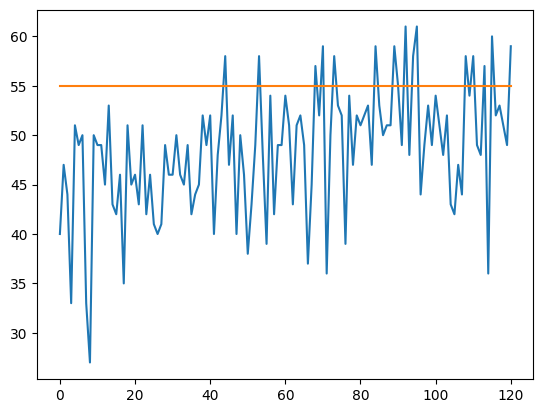

In [ ]:
import matplotlib.pyplot as plt

plt.plot(win_history)
plt.plot([55] * len(win_history))
plt.show()